In [1]:
%%capture capt --no-stdout
ret = !pip3 list --format=columns | grep -e '^n2 ' | awk '{print $2}'
n2_ver = ret[0]
ret = !pip3 list --format=columns | grep -e '^nmslib ' | awk '{print $2}'
nmslib_ver = ret[0]

In [30]:
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt

from tabulate import tabulate

dataset = 'youtube1m-40-angular'
metric = 'angular'
build_threads = [1, 2, 4, 8, 16]
libs = ('N2', 'nmslib')

test_environment = f"""CPU: Intel Xeon E5-2620 v4
Memory: 64GB
Storage: SSD
Dataset: Youtube(5.4GB)
N2 version: {n2_ver}
nmslib version: {nmslib_ver}"""

In [18]:
%%capture capt
!rm -rf cache
!rm -rf result

for t in build_threads:
    !python3 benchmark_script.py --distance {metric} --dataset {dataset} --n_threads {t} --build_only

In [20]:
result = {}
for l in open(f'./result/result_{dataset}_100_3.txt'):
    _, lib_param, build_time, _, _, memory_usage = l.strip().split('\t')
    result[lib_param] = (float(build_time), float(memory_usage))

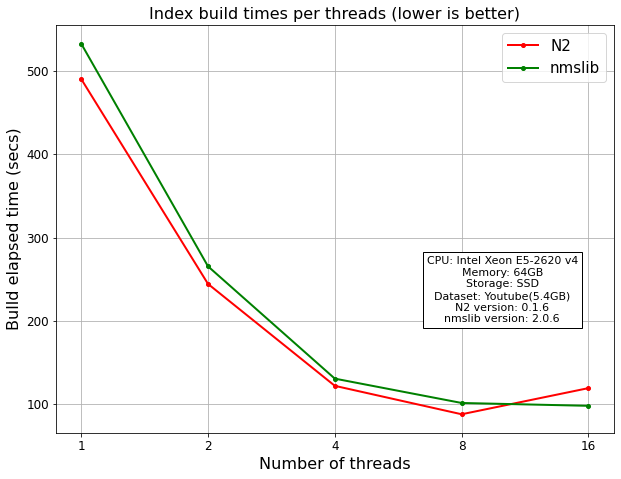

+----------------+------------+-------------+-------------+-------------+--------------+
| Library        | 1 thread   | 2 threads   | 4 threads   | 8 threads   | 16 threads   |
+================+============+=============+=============+=============+==============+
| N2 (254MB)     | 490.05 sec | 244.4 sec   | 122.23 sec  | 88.15 sec   | 119.5 sec    |
+----------------+------------+-------------+-------------+-------------+--------------+
| nmslib (269MB) | 532.41 sec | 265.46 sec  | 130.87 sec  | 101.69 sec  | 98.28 sec    |
+----------------+------------+-------------+-------------+-------------+--------------+


In [27]:
n2_build_times = []
nmslib_build_times = []
for t in build_threads:
    n2_build_times.append(result[f'N2_M12_efCon100_n_thread{t}_efSearch25'][0])
    nmslib_build_times.append(result[f'nmslib_M12_efCon100_n_thread{t}_efSearch25'][0])
    
fig = plt.figure(figsize=(10, 7.5))
plt.title('Index build times per threads (lower is better)', fontsize=16)
plt.ylabel('Bulld elapsed time (secs)', fontsize=16)
plt.xlabel('Number of threads', fontsize=16)
plt.text(0.8, 0.35, test_environment, color='black', 
         bbox=dict(facecolor='white', edgecolor='black'), size=11,
         horizontalalignment='center', verticalalignment='center',
         transform=plt.gca().transAxes)
x = range(len(build_threads))
plt.plot(x, n2_build_times, 'ro-',label='N2', linewidth=2, ms=4)
plt.plot(x, nmslib_build_times, 'go-', label='nmslib', linewidth=2, ms=4)
plt.xticks(x, build_threads, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 15})
plt.grid()
plt.show()

ret = !ls -hs cache/index_n2_{dataset}_M12_efCon100_n_thread{build_threads[-1]} | cut -d' ' -f1
n2_index_size = ret[0]
ret = !ls -hs cache/index_nmslib_{dataset}_M12_efCon100_n_thread{build_threads[-1]} | cut -d' ' -f1
nmslib_index_size = ret[0]

headers = ['Library']
for t in build_threads:
    if t == 1:
        headers.append(f'{t} thread')
    else:
        headers.append(f'{t} threads')
table = [
    [f'N2 (IndexSize: {n2_index_size}B)'] + [f'{round(time, 2)} sec' for time in n2_build_times],
    [f'nmslib (IndexSize: {nmslib_index_size}B)'] + [f'{round(time, 2)} sec' for time in nmslib_build_times]
]
print(tabulate(table, headers, tablefmt="grid"))

compare = [round((nmslib - n2) / nmslib, 2) * 100 for n2, nmslib in zip(n2_build_times, nmslib_build_times)]

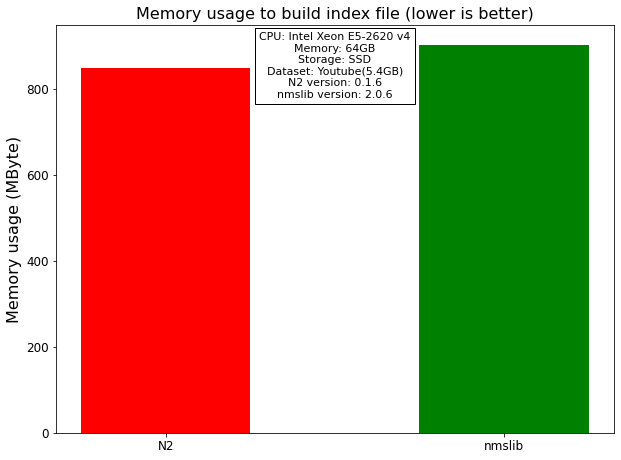

+-----------+----------------+
| Library   | memory usage   |
+===========+================+
| N2        | 848.53 MB      |
+-----------+----------------+
| nmslib    | 902.61 MB      |
+-----------+----------------+


In [25]:
memory_usages = [result[f'{lib}_M12_efCon100_n_thread16_efSearch25'][1] / 1024 for lib in libs]

fig = plt.figure(figsize=(10, 7.5))
y = range(len(libs))
plt.title('Memory usage to build index file (lower is better)', fontsize=16)
plt.ylabel('Memory usage (MByte)', fontsize=16)
plt.bar(y, memory_usages, width = 0.5, color=['r', 'g'])
plt.xticks(y, libs, fontsize=12)
plt.yticks(fontsize=12)
plt.text(0.5, 0.9, test_environment, color='black', 
         bbox=dict(facecolor='none', edgecolor='black'), size=11,
         horizontalalignment='center', verticalalignment='center',
         transform=plt.gca().transAxes)
plt.show()

headers = ['Library', 'memory usage']
table = [[lib, f'{round(usage, 2)} MB'] for lib, usage in zip(libs, memory_usages)]

print(tabulate(table, headers, tablefmt="grid"))



In [28]:
%%capture capt
!rm -rf result
!python3 benchmark_script.py --distance {metric} --dataset {dataset} --n_threads {build_threads[-1]} 

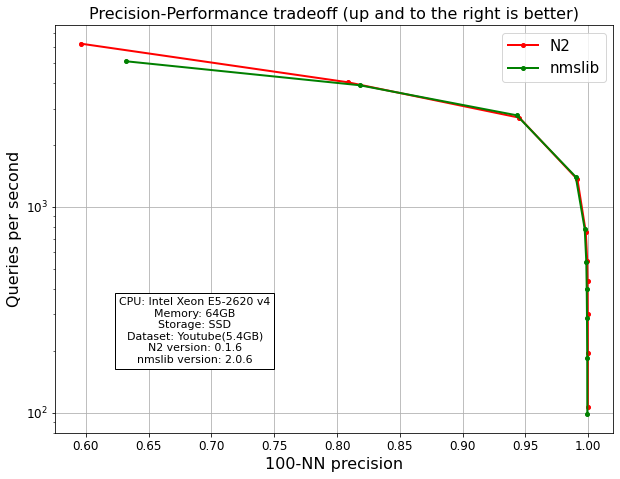

+-----------------------------------+--------------------+-----------------+------------------------+---------------------+
| Parameter                         |   search time (N2) |   accuracy (N2) |   search time (nmslib) |   accuracy (nmslib) |
+===================================+====================+=================+========================+=====================+
| M: 12, efCon: 100, efSearch: 25   |        0.000161148 |        0.595976 |            0.000196341 |            0.632241 |
+-----------------------------------+--------------------+-----------------+------------------------+---------------------+
| M: 12, efCon: 100, efSearch: 50   |        0.000248176 |        0.808453 |            0.000256654 |            0.81796  |
+-----------------------------------+--------------------+-----------------+------------------------+---------------------+
| M: 12, efCon: 100, efSearch: 100  |        0.000369059 |        0.945182 |            0.000359272 |            0.943038 |
+-------

In [79]:
result = defaultdict(list)
for l in open(f'./result/result_{dataset}_100_3.txt'):
    lib, lib_param, _, search_elapsed, precision, _ = l.strip().split('\t')
    result[lib].append((float(search_elapsed), float(precision), lib_param))
    
n2_result = sorted(result['n2'])
n2_qps = [1/r[0] for r in n2_result]
n2_precision = [r[1] for r in n2_result]

nmslib_result = sorted(result['nmslib'])
nmslib_qps = [1/r[0] for r in nmslib_result]
nmslib_precision = [r[1] for r in nmslib_result]

fig = plt.figure(figsize=(10, 7.5))
plt.title('Precision-Performance tradeoff (up and to the right is better)', fontsize=16)
plt.ylabel('Queries per second', fontsize=16)
plt.xlabel('100-NN precision', fontsize=16)
plt.text(0.25, 0.25, test_environment, color='black', 
         bbox=dict(facecolor='white', edgecolor='black'), size=11,
         horizontalalignment='center', verticalalignment='center',
         transform=plt.gca().transAxes)
plt.plot(n2_precision, n2_qps, 'ro-', label='N2', linewidth=2, ms=4)
plt.plot(nmslib_precision, nmslib_qps, 'go-', label='nmslib', linewidth=2, ms=4)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.legend(prop={'size': 15})
plt.grid()
plt.show()

headers = ['Parameter', 'search time (N2)', 'accuracy (N2)', 'search time (nmslib)', 'accuracy (nmslib)']
table = [[n2[2].split('_')[1].replace('M', 'M: ') + ', ' +
          n2[2].split('_')[2].replace('Con', 'Con: ') + ', ' + 
          n2[2].split('_')[5].replace('Search', 'Search: '), n2[0], n2[1], nmslib[0], nmslib[1]] 
         for n2, nmslib in zip(n2_result, nmslib_result)]
print(tabulate(table, headers, tablefmt="grid"))